taken from https://github.com/karpathy/nn-zero-to-hero/tree/master/lectures/micrograd

### Playing around

In [1]:
ls = [1,2,3 ]

In [2]:
dir(ls)

['__add__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [13]:
ls * 5

[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]

In [14]:
(ls.__mul__(5))

[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]

In [9]:
ls.__iter__()

### Make an expression visualizer

In [20]:
from graphviz import Digraph

In [21]:
a = Digraph('hello', format = 'png')

In [30]:
a.node('a', label = '{a | b}', shape = 'record')
a.node('b', shape= 'circle')

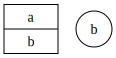

In [31]:
a

In [232]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                print(child)
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [355]:
class Value:
    def __init__(self,data, _children = (), _op = '', label=None):
        self.data = data
        self.label = label
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        
    def __repr__(self):
        return f"Value({self.label}, {self.data})"
    
    def __add__(self, other):
        def _backward(self):
            self._prev[0].grad = self.grad
            self._prev[1].grad = self.grad
            
        result = Value(self.data + other.data, (self, other), '+')
        result._backward = _backward
        return result 

    def __sub__(self,other):
        result = Value(self.data - other.data)
        result._prev = [self, other]
        result._op = '-'
        return result
    
    def __mul__(self,other):
        
        def _backward(self):
            print('gg', self.grad)
            self._prev[0].grad = self.grad * self._prev[1].data
            self._prev[1].grad = self.grad * self._prev[0].data
        
        result = Value(self.data * other.data, (self, other), '*')
        result._backward = _backward
        return result
    
    
    

    def backward(self):
        print(self)
        topo = []
        visited = set()


        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
            
        
        build_topo(self)
        topo = list(reversed(topo))
        
        print(topo)
            
        for i in topo:
            if i._op != '':
                print(i)
                i._backward(i._prev)
        

    

In [356]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(L, -8.0)

In [357]:
L.grad = 1

In [358]:
L.backward()

Value(L, -8.0)
[Value(L, -8.0), Value(d, 4.0), Value(e, -6.0), Value(b, -3.0), Value(a, 2.0), Value(c, 10.0), Value(f, -2.0)]
Value(L, -8.0)


AttributeError: 'set' object has no attribute 'grad'

In [288]:



build_topo(L)
topo


[Value(a, 2.0),
 Value(b, -3.0),
 Value(e, -6.0),
 Value(c, 10.0),
 Value(d, 4.0),
 Value(f, -2.0),
 Value(L, -8.0)]

In [292]:
ls = list(reversed(topo))

In [293]:
ls

[Value(L, -8.0),
 Value(f, -2.0),
 Value(d, 4.0),
 Value(c, 10.0),
 Value(e, -6.0),
 Value(b, -3.0),
 Value(a, 2.0)]